# Combining Grounding DINO with Segment Anything (SAM) for text-based mask generation

In this notebook, we're going to combine 2 very cool models - [Grounding DINO](https://huggingface.co/docs/transformers/main/en/model_doc/grounding-dino) and [SAM](https://huggingface.co/docs/transformers/en/model_doc/sam). We'll use Grounding DINO to generate bounding boxes based on text prompts, after which we can prompt SAM to generate corresponding segmentation masks for them.

This is based on the popular [Grounded Segment Anything](https://github.com/IDEA-Research/Grounded-Segment-Anything) project - just with fewer lines of code as the models are now available in the Transformers library. Refer to the [paper](https://arxiv.org/abs/2401.14159) for details.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/grounded_sam.png"
alt="drawing" width="900"/>

<small> Grounded SAM overview. Taken from the <a href="https://github.com/IDEA-Research/Grounded-Segment-Anything">original repository</a>. </small>

Author of this notebook: [Eduardo Pacheco](https://huggingface.co/EduardoPacheco) - give him a follow on Hugging
 Face!

## Set-up environment

Let's start by installing 🤗 Transformers from source since Grounding DINO is brand new at the time of writing.

In [ ]:
pip install --upgrade -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cropped_manual.png to cropped_manual (2).png


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = '/content/drive/MyDrive/cropped_manual.png'

In [ ]:
image_path = list(uploaded.keys())[0]

## Imports

Let's start by importing the required libraries.

In [ ]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

## Result Utils

We'll store the detection results of Grounding DINO in a dedicated Python dataclass.

In [ ]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

## Plot Utils

Below, some utility functions are defined as we'll draw the detection results of Grounding DINO on top of the image.

In [ ]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [ ]:
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]


    fig = px.imshow(image)

    # Add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color=class_colors[idx], width=2),
            fill='toself',
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=class_colors[idx])
            )
        ]
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()


## Utils

In [ ]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

## Grounded Segment Anything (SAM)

Now it's time to define the Grounded SAM approach!

The approach is very simple:
1. use Grounding DINO to detect a given set of texts in the image. The output is a set of bounding boxes.
2. prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

In [ ]:
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=-1)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    device = "cpu"  # Force CPU even if GPU is available
    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

### Inference

Let's showcase Grounded SAM on our favorite image: the cats image from the COCO dataset.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import spacy

# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")



# The task prompt ( as provided by the user)
task = "Locate the apple and banana then pick the apple."


doc = nlp(task)

extracted_chunks = [chunk.text for chunk in doc.noun_chunks]

def convert_to_label(noun_phrase):
    """
    Convert a noun phrase to a label by ensuring it starts with "a"
    and ends with a period.
    """
    words = noun_phrase.split()
    if words[0].lower() in ["a", "an", "the"]:
        # Replace the determiner with "a"
        words[0] = "a"
    else:
        # If there is no determiner, simply insert "a" at the beginning.
        words.insert(0, "a")
    label = " ".join(words)
    # Append a period if the label doesn't already end with one.
    if not label.endswith("."):
        label += "."
    return label

# Apply conversion to each extracted noun phrase
labels = [convert_to_label(chunk) for chunk in extracted_chunks]

# Optionally, combine the labels into a single string if desired
labels_combined = ", ".join(labels)

print("Extracted labels as list:", labels)
print("Extracted labels as combined string:", labels_combined)

Extracted labels as list: ['a apple.', 'a banana.']
Extracted labels as combined string: a apple., a banana.


In [ ]:
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image_path = "human.jpeg"
# image_path = "fruits.jpg"
image_path = image_path
labels = labels
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

In [ ]:
image_array, detections = grounded_segmentation(
    # image=image_url,
    image = image_path,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)

Device set to use cpu


Let's visualize the results:

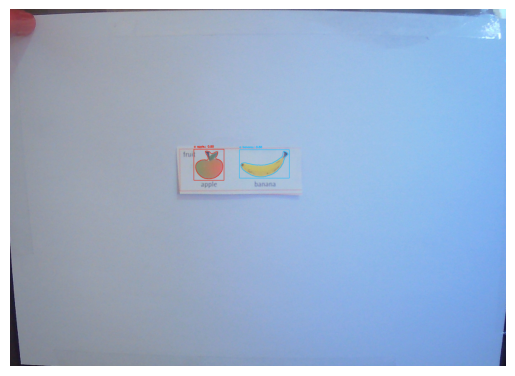

In [ ]:
# plot_detections(image_array, detections, "cute_cats.png")
plot_detections(image_array, detections)

In [ ]:
plot_detections_plotly(image_array, detections)

In [ ]:
# Print the first detection to inspect its attributes:
print("Detection 0 details:", detections[0])
print("Attributes of Detection 0:", dir(detections[0]))


Detection 0 details: DetectionResult(score=0.8765403628349304, label='a banana.', box=BoundingBox(xmin=1285, ymin=788, xmax=1565, ymax=947), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
Attributes of Detection 0: ['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'box', 'from_dict', 'label', 'mask', 'score']


In [ ]:
def compute_center(bbox):
    """
    Compute the center (x, y) of a bounding box.

    Parameters:
        bbox (list or tuple): Bounding box coordinates in the form [x_min, y_min, x_max, y_max].

    Returns:
        tuple: Center point (x_center, y_center).
    """
    if not bbox or len(bbox) != 4:
        raise ValueError("Bounding box must have four elements: [x_min, y_min, x_max, y_max].")
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    return (x_center, y_center)

def extract_all_poses(detections):
    """
    Extract the center positions (poses) from a list of detection results.

    This function handles both dictionary-based detections (with a 'bbox' or 'box' key)
    and object-based detections (with a .box attribute).

    Parameters:
        detections (iterable): Iterable of detection results.

    Returns:
        list: List of (x, y) tuples representing the center of each detected object.
    """
    poses = []
    for i, detection in enumerate(detections):
        bbox = None
        # Check if detection is dictionary-like
        if isinstance(detection, dict):
            bbox = detection.get("bbox", detection.get("box", None))
            # If it's dictionary-based and bbox/box is found but is not in list form,
            # make sure to convert it appropriately.
            if bbox and isinstance(bbox, dict):
                # Try to extract coordinates if bbox is a dict with expected keys.
                bbox = [bbox.get("xmin"), bbox.get("ymin"), bbox.get("xmax"), bbox.get("ymax")]
        # Otherwise, for object-based detections, use the 'box' attribute.
        elif hasattr(detection, "box"):
            # The 'box' attribute is a BoundingBox object, so extract its properties.
            bbox_obj = detection.box
            bbox = [bbox_obj.xmin, bbox_obj.ymin, bbox_obj.xmax, bbox_obj.ymax]
        else:
            print(f"Detection {i} does not have a bounding box. Skipping.")
            continue

        if bbox is None:
            print(f"Detection {i} has no valid bounding box. Skipping.")
            continue

        try:
            center = compute_center(bbox)
            poses.append(center)
        except Exception as e:
            print(f"Error computing center for detection {i}: {e}")
            continue
    return poses

# ----------------------------------------------------------------------------
# Use the function with your existing detections variable produced in your pipeline.
# ----------------------------------------------------------------------------

poses = extract_all_poses(detections)
print("Detected objects' poses (centers):", poses)

Detected objects' poses (centers): [(1425.0, 867.5), (1114.5, 872.0)]


In [ ]:
import plotly.graph_objects as go
import base64
from io import BytesIO
from PIL import Image
import cv2

def plot_segmented_image_with_poses(image_array, detections, poses):
    height, width = image_array.shape[:2]

    # Convert the image to a base64 string
    pil_img = Image.fromarray(image_array)
    buffer = BytesIO()
    pil_img.save(buffer, format="PNG")
    img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # Create Plotly figure
    fig = go.Figure()

    # Add the base image as a layout image
    fig.add_layout_image(
        dict(
            source="data:image/png;base64," + img_str,
            x=0,
            y=0,
            sizex=width,
            sizey=height,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below"
        )
    )

    # (A) Add bounding boxes from detections
    for detection in detections:
        box = detection.box  # bounding box with .xmin, .ymin, .xmax, .ymax
        fig.add_shape(
            type="rect",
            x0=box.xmin,
            y0=box.ymin,
            x1=box.xmax,
            y1=box.ymax,
            line=dict(color="blue", width=2),
            fillcolor="rgba(0,0,255,0.1)"
        )

        # (B) Add the mask as a polygon
        # If detection.mask is a 2D array with 1 for object, 0 for background
        contours, _ = cv2.findContours(detection.mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            contour_points = contour.reshape(-1, 2)  # Nx2 array
            path = "M " + " L ".join(f"{x},{y}" for x,y in contour_points) + " Z"
            fig.add_shape(
                type="path",
                path=path,
                fillcolor="rgba(255, 0, 0, 0.4)",
                line=dict(color="rgba(255, 0, 0, 0.4)"),
            )

    # (C) Add pose markers
    for pose in poses:
        x, y = pose
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode='markers+text',
            marker=dict(color='red', size=10),
            text=["({:.1f}, {:.1f})".format(x, y)],
            textposition="top center",
            name="Center"
        ))

    # Ensure top-left origin
    fig.update_xaxes(range=[0, width], scaleanchor="y", scaleratio=1, visible=False)
    fig.update_yaxes(range=[height, 0], visible=False)

    fig.update_layout(title="Segmented Image with Detection Centers")
    fig.show()

# Then call:
plot_segmented_image_with_poses(image_array, detections, poses)


In [ ]:
print(poses)

[(1425.0, 867.5), (1114.5, 872.0)]


In [ ]:
def pixel_to_cm(pose_pixels, img_width_px, img_height_px, real_width_cm, real_height_cm):
    converted = []
    for (x_pixel, y_pixel) in pose_pixels:
        x_cm = (x_pixel / img_width_px) * real_width_cm
        y_cm = (y_pixel / img_height_px) * real_height_cm
        converted.append((x_cm, y_cm))
    return converted

# Example
poses = [(1425, 867.5), (1114.5, 872.0)]

real_world_poses = pixel_to_cm(
    poses,
    img_width_px=2780,
    img_height_px=2000,
    real_width_cm=30,
    real_height_cm=20.5
)

for i, (x_cm, y_cm) in enumerate(real_world_poses):
    print(f"Pose {i+1}: ({x_cm:.2f} cm, {y_cm:.2f} cm)")


Pose 1: (15.38 cm, 8.89 cm)
Pose 2: (12.03 cm, 8.94 cm)


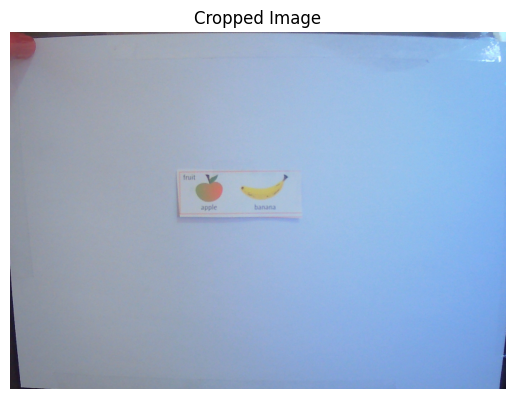

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# Load the image
img = cv2.imread(image_path)

# Manual crop coordinates
x = 500
y = 75
w = 2780
h = 2000

# Crop
cropped = img[y:y+h, x:x+w]

# Save inside Colab
cv2.imwrite('cropped_manual.png', cropped)

# Show
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Cropped Image')
plt.show()

# Download to your computer
files.download('cropped_manual.png')
